In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [2]:
# Loading the training dataset from ./data/train.sources

with open('./data/train.sources') as f:
    train_sources = f.readlines()
train_sources = [x.strip() for x in train_sources]
print(train_sources[0])
print(len(train_sources))

[{"str0": "H4PA10062", "str1": "TROIANO, NICHOLAS ROBERT", "str2": "C", "num0": 3, "str3": "IND", "num1": 0, "num2": "0", "num3": 3369.16, "num4": 0, "num5": 3369.16, "num6": 0, "num7": 0, "num8": 0, "num9": "0", "num10": 0, "num11": 0, "num12": 0, "num13": 0, "str4": "PA", "num14": 10, "num15": "0", "num16": 0, "dt0": "01/08/2015", "num17": 0, "num18": "0"}]
172719


In [273]:
# Loading the development dataset from ./data/dev.sources

with open('./data/dev.sources') as f:
    dev_sources = f.readlines()
dev_sources = [x.strip() for x in dev_sources]
print(dev_sources[0])
print(len(dev_sources))


[{"num0": 6.4, "num1": 3.2, "num2": 4.5, "num3": 1.5, "str0": "versicolor"}]
21590


In [3]:
# Loading the testing dataset from ./data/test.sources

with open('./data/test.sources') as f:
    test_sources = f.readlines()
test_sources = [x.strip() for x in test_sources]
print(test_sources[0])
print(len(test_sources))

[{"str0": "Once in a Lifetime: the Extraordinary Story of the New York Cosmos", "num0": 144601, "num1": 206351, "num2": null, "num3": 1000000, "dt0": "7-Jul-06", "str1": "PG-13", "num4": null, "str2": "Miramax", "str3": "Based on Real Life Events", "str4": "Documentary", "str5": "Factual", "str6": "Matt Dillon", "num5": 82, "num6": 7.1, "num7": 643}]
21590


In [4]:
# Importing the target dataset from ./data/train.targets
with open('./data/train.targets') as f:
    train_targets = f.readlines()

train_targets = [x.strip() for x in train_targets]
print(train_targets[0])
print(len(train_targets))

{"encoding": {"color": {"field": "str3", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "num5", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative"}}, "mark": "point"}
172719


In [274]:
# Importing the development dataset from ./data/dev.targets
with open('./data/dev.targets') as f:
    dev_targets = f.readlines()

dev_targets = [x.strip() for x in dev_targets]
print(dev_targets[0])
print(len(dev_targets))

{"encoding": {"detail": {"field": "str0", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "num2", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative"}}, "mark": "line"}
21590


In [5]:
# Importing the target dataset from ./data/test.targets
with open('./data/test.targets') as f:
    test_targets = f.readlines()

test_targets = [x.strip() for x in test_targets]
print(test_targets[0])
print(len(test_targets))

{"encoding": {"y": {"field": "dt0", "type": "temporal", "timeUnit": "year"}, "x": {"field": "num3", "type": "quantitative"}}, "mark": "circle"}
21590


In [275]:
max_source_len = 0
max_target_len = 0

for i in range(len(train_sources)):
    max_source_len = max(max_source_len, len(train_sources[i]))
    max_target_len = max(max_target_len, len(train_targets[i]))

for i in range(len(test_sources)):
    max_source_len = max(max_source_len, len(test_sources[i]))
    max_target_len = max(max_target_len, len(test_targets[i]))

for i in range(len(dev_sources)):
    max_source_len = max(max_source_len, len(dev_sources[i]))
    max_target_len = max(max_target_len, len(dev_targets[i]))

print(max_source_len)
print(max_target_len)



374
263


In [7]:
# Creating the vocabulary class for character level encoding
class Vocabulary:
    def __init__(self):
        self.char2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.idx2char = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.char_count = {}

    def add_char(self, char):
        if char not in self.char2idx:
            self.char2idx[char] = len(self.char2idx)
            self.idx2char[len(self.idx2char)] = char
            self.char_count[char] = 1
        else:
            self.char_count[char] += 1

    def add_sentence(self, sentence):
        for char in sentence:
            self.add_char(char)

    def __len__(self):
        return len(self.char2idx)


In [8]:
# Creating the vocabulary for source and target
source_vocab = Vocabulary()
target_vocab = Vocabulary()

for i in range(len(train_sources)):
    source_vocab.add_sentence(train_sources[i])
    target_vocab.add_sentence(train_targets[i])

print(len(source_vocab))
print(len(target_vocab))

89
47


In [9]:
print(source_vocab.char_count)
print(target_vocab.char_count)

print(source_vocab.char2idx)
print(target_vocab.char2idx)

{'[': 172719, '{': 172719, '"': 6958572, 's': 1027860, 't': 1229422, 'r': 1200379, '0': 2109195, ':': 2425183, ' ': 5170489, 'H': 97192, '4': 499958, 'P': 89494, 'A': 279130, '1': 1351670, '6': 412607, '2': 749857, ',': 2256380, 'T': 157886, 'R': 204838, 'O': 125050, 'I': 177971, 'N': 221177, 'C': 149466, 'L': 162237, 'S': 210995, 'B': 82137, 'E': 200154, 'n': 1935969, 'u': 1664397, 'm': 1578255, '3': 603405, 'D': 136044, '9': 293685, '.': 182160, '5': 525618, '7': 390581, '8': 328975, 'd': 264510, '/': 159504, '}': 172719, ']': 172719, 'G': 50477, 'X': 7266, 'o': 414444, 'e': 433558, 'U': 76605, 'V': 14712, 'J': 28789, 'w': 46215, 'y': 119243, 'p': 115143, 'a': 402984, 'c': 181025, 'h': 101754, 'l': 466883, 'i': 364420, 'g': 83043, 'Z': 7050, 'M': 112696, 'v': 49546, 'b': 59290, '-': 215322, 'F': 67037, 'K': 33654, 'W': 44327, 'k': 62500, "'": 4583, 'x': 13343, 'Y': 27460, 'f': 30569, '(': 5382, ')': 5382, 'j': 1008, '*': 3523, 'z': 5594, '\\': 345, '!': 211, 'Q': 375, 'q': 723, '&': 

In [10]:
source_vocab.idx2char

{0: '<pad>',
 1: '<sos>',
 2: '<eos>',
 3: '<unk>',
 4: '[',
 5: '{',
 6: '"',
 7: 's',
 8: 't',
 9: 'r',
 10: '0',
 11: ':',
 12: ' ',
 13: 'H',
 14: '4',
 15: 'P',
 16: 'A',
 17: '1',
 18: '6',
 19: '2',
 20: ',',
 21: 'T',
 22: 'R',
 23: 'O',
 24: 'I',
 25: 'N',
 26: 'C',
 27: 'L',
 28: 'S',
 29: 'B',
 30: 'E',
 31: 'n',
 32: 'u',
 33: 'm',
 34: '3',
 35: 'D',
 36: '9',
 37: '.',
 38: '5',
 39: '7',
 40: '8',
 41: 'd',
 42: '/',
 43: '}',
 44: ']',
 45: 'G',
 46: 'X',
 47: 'o',
 48: 'e',
 49: 'U',
 50: 'V',
 51: 'J',
 52: 'w',
 53: 'y',
 54: 'p',
 55: 'a',
 56: 'c',
 57: 'h',
 58: 'l',
 59: 'i',
 60: 'g',
 61: 'Z',
 62: 'M',
 63: 'v',
 64: 'b',
 65: '-',
 66: 'F',
 67: 'K',
 68: 'W',
 69: 'k',
 70: "'",
 71: 'x',
 72: 'Y',
 73: 'f',
 74: '(',
 75: ')',
 76: 'j',
 77: '*',
 78: 'z',
 79: '\\',
 80: '!',
 81: 'Q',
 82: 'q',
 83: '&',
 84: '?',
 85: '@',
 86: '+',
 87: '#',
 88: '$'}

In [11]:
# Creating the dataset class with padding
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sources, targets, source_vocab, target_vocab, max_source_len, max_target_len):
        self.sources = sources
        self.targets = targets
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        self.max_source_len = max_source_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, index):
        source = self.sources[index]
        target = self.targets[index]

        source_encoded = [self.source_vocab.char2idx['<sos>']]
        for char in source:
            if char in self.source_vocab.char2idx:
                source_encoded.append(self.source_vocab.char2idx[char])
            else:
                source_encoded.append(self.source_vocab.char2idx['<unk>'])
        source_encoded.append(self.source_vocab.char2idx['<eos>'])

        target_encoded = [self.target_vocab.char2idx['<sos>']]
        for char in target:
            if char in self.target_vocab.char2idx:
                target_encoded.append(self.target_vocab.char2idx[char])
            else:
                target_encoded.append(self.target_vocab.char2idx['<unk>'])
        target_encoded.append(self.target_vocab.char2idx['<eos>'])

        source_padded = source_encoded + [self.source_vocab.char2idx['<pad>']] * (self.max_source_len - len(source_encoded))
        target_padded = target_encoded + [self.target_vocab.char2idx['<pad>']] * (self.max_target_len - len(target_encoded))

        return torch.tensor(source_padded), torch.tensor(target_padded)

In [12]:
# Creating the training and validation dataset
max_source_len = max_source_len + 2
max_target_len = max_target_len + 2
train_dataset = Dataset(train_sources, train_targets, source_vocab, target_vocab, max_source_len, max_target_len)


# Creating the training and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)


In [276]:
# Creating the development dataset
dev_dataset = Dataset(dev_sources, dev_targets, source_vocab, target_vocab, max_source_len, max_target_len)

dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=4, shuffle=True)

In [13]:
# Creating the testing dataset
test_dataset = Dataset(test_sources, test_targets, source_vocab, target_vocab, max_source_len, max_target_len)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

In [14]:
from torch.autograd import Variable
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size,
                 n_layers=1, dropout=0.5):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.embed = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, n_layers,
                          dropout=dropout, bidirectional=True)

    def forward(self, src, hidden=None):
        embedded = self.embed(src)
        outputs, hidden = self.gru(embedded, hidden)
        outputs = (outputs[:, :, :self.hidden_size] +
                   outputs[:, :, self.hidden_size:])
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1) 
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = F.relu(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2) 
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1) 
        energy = torch.bmm(v, energy)  
        return energy.squeeze(1) 


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, output_size,
                 n_layers=1, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.embed = nn.Embedding(output_size, embed_size)
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(hidden_size + embed_size, hidden_size,
                          n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input, last_hidden, encoder_outputs):
        embedded = self.embed(input).unsqueeze(0) 
        embedded = self.dropout(embedded)
        attn_weights = self.attention(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) 
        context = context.transpose(0, 1)
        rnn_input = torch.cat([embedded, context], 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        output = output.squeeze(0)  # (1,B,N) -> (B,N)
        context = context.squeeze(0)
        output = self.out(torch.cat([output, context], 1))
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(1)
        max_len = trg.size(0)
        vocab_size = self.decoder.output_size
        outputs = Variable(torch.zeros(max_len, batch_size, vocab_size)).cuda()

        encoder_output, hidden = self.encoder(src)
        hidden = hidden[:self.decoder.n_layers]
        output = Variable(trg.data[0, :])  # sos
        for t in range(1, max_len):
            output, hidden, attn_weights = self.decoder(
                    output, hidden, encoder_output)
            outputs[t] = output
            is_teacher = np.random.random() < teacher_forcing_ratio
            top1 = output.data.max(1)[1]
            output = Variable(trg.data[t] if is_teacher else top1).cuda()
        return outputs

In [40]:
# Creating the model
INPUT_DIM = len(source_vocab)
OUTPUT_DIM = len(target_vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(DEC_EMB_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(89, 256)
    (gru): GRU(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(47, 256)
    (dropout): Dropout(p=0.5, inplace=True)
    (attention): Attention(
      (attn): Linear(in_features=512, out_features=256, bias=True)
    )
    (gru): GRU(512, 256, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=47, bias=True)
  )
)

In [30]:
# Use first batch from train_dataloader to test the model
batch = next(iter(train_dataloader))
source = batch[0].to(device)
target = batch[1].to(device)
source=source.permute(1,0)
target=target.permute(1,0)

print(source.shape)
print(target.shape)

# Testing the model
output = model(source, target)
print(output.shape)

torch.Size([376, 4])
torch.Size([265, 4])
torch.Size([265, 4, 47])


In [41]:
# Counting the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,148,847 trainable parameters


In [32]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2564 MiB |   2607 MiB |  10245 GiB |  10242 GiB |
|       from large pool |   2501 MiB |   2556 MiB |  10135 GiB |  10133 GiB |
|       from small pool |     63 MiB |     63 MiB |    110 GiB |    109 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2564 MiB |   2607 MiB |  10245 GiB |  10242 GiB |
|       from large pool |   2501 MiB |   2556 MiB |  10135 GiB |

In [33]:
# Count the number of batches in the train_dataloader
num_batches = len(train_dataloader)
print(num_batches)
num_batches = len(test_dataloader)
print(num_batches)

43180
5398


In [42]:
losses = []

In [43]:
# Defining the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Training the model
model.train()

for epoch in range(1):
    epoch_loss = 0
    for iteration, batch in enumerate(train_dataloader):
        source = batch[0].to(device)
        target = batch[1].to(device)
        source = source.permute(1, 0)
        target = target.permute(1, 0)
        optimizer.zero_grad()
        output = model(source, target)
        output =output.permute(1,2,0)
        target = target.permute(1,0)
        #print(output.shape, target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        losses.append(loss.item())
        print("Batch: ", iteration, "Loss: ", loss.item())
        if(iteration>200):
            break
    print("Epoch: ", epoch, "Epoch Loss: ", epoch_loss)

Batch:  0 Loss:  3.8662450313568115
Batch:  1 Loss:  3.3926143646240234
Batch:  2 Loss:  3.2016782760620117
Batch:  3 Loss:  3.0832767486572266
Batch:  4 Loss:  3.0788521766662598
Batch:  5 Loss:  3.02580189704895
Batch:  6 Loss:  3.0315282344818115
Batch:  7 Loss:  2.987089157104492
Batch:  8 Loss:  3.0125653743743896
Batch:  9 Loss:  2.9653022289276123
Batch:  10 Loss:  2.9566807746887207
Batch:  11 Loss:  2.9003372192382812
Batch:  12 Loss:  2.9137699604034424
Batch:  13 Loss:  2.8995282649993896
Batch:  14 Loss:  2.8585824966430664
Batch:  15 Loss:  2.838686466217041
Batch:  16 Loss:  2.8236987590789795
Batch:  17 Loss:  2.796321392059326
Batch:  18 Loss:  2.7391035556793213
Batch:  19 Loss:  2.6742324829101562
Batch:  20 Loss:  2.622162103652954
Batch:  21 Loss:  2.6417531967163086
Batch:  22 Loss:  2.6204960346221924
Batch:  23 Loss:  2.589695453643799
Batch:  24 Loss:  2.5216996669769287
Batch:  25 Loss:  2.5437395572662354
Batch:  26 Loss:  2.4369473457336426
Batch:  27 Loss:  

In [281]:
# Defining the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Training the model with validation
model.train()

def train_and_validate(model, train_dataloader, dev_dataloader, criterion, optimizer, num_epochs=1,start_batch=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        for iteration, batch in enumerate(train_dataloader):
            if(iteration<start_batch):
                continue
            source = batch[0].to(device)
            target = batch[1].to(device)
            source = source.permute(1, 0)
            target = target.permute(1, 0)
            optimizer.zero_grad()
            output = model(source, target)
            output = output.permute(1, 2, 0)
            target = target.permute(1, 0)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("Epoch {}, Batch {}: Loss {}".format(epoch, iteration, loss.item()))
            if(iteration>50+start_batch):
                break

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch in dev_dataloader:
                if(iteration<start_batch):
                    continue
                val_source = val_batch[0].to(device)
                val_target = val_batch[1].to(device)
                val_source = val_source.permute(1, 0)
                val_target = val_target.permute(1, 0)
                val_output = model(val_source, val_target)
                val_output = val_output.permute(1, 2, 0)
                val_target = val_target.permute(1, 0)
                val_loss += criterion(val_output, val_target).item()
                if(iteration>50+start_batch):
                    break

        avg_val_loss = val_loss / len(dev_dataloader)
        print("Epoch {}: Training Loss {}, Validation Loss {}".format(epoch, epoch_loss, avg_val_loss))
        
    
    print("Training and validation completed.")


In [282]:
lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
# Training the model with validation
train_and_validate(model, train_dataloader, dev_dataloader, criterion, optimizer, num_epochs=1,start_batch=250)

Epoch 0, Batch 250: Loss 0.2438480705022812
Epoch 0, Batch 251: Loss 0.2998332977294922
Epoch 0, Batch 252: Loss 0.10112271457910538
Epoch 0, Batch 253: Loss 0.16473548114299774
Epoch 0, Batch 254: Loss 0.29638510942459106
Epoch 0, Batch 255: Loss 0.273607462644577
Epoch 0, Batch 256: Loss 0.15211792290210724
Epoch 0, Batch 257: Loss 0.12065649777650833
Epoch 0, Batch 258: Loss 0.2108355462551117
Epoch 0, Batch 259: Loss 0.19890575110912323
Epoch 0, Batch 260: Loss 0.24561873078346252
Epoch 0, Batch 261: Loss 0.24322029948234558
Epoch 0, Batch 262: Loss 0.12531131505966187
Epoch 0, Batch 263: Loss 0.21521860361099243
Epoch 0, Batch 264: Loss 0.16767185926437378
Epoch 0, Batch 265: Loss 0.187087744474411
Epoch 0, Batch 266: Loss 0.19754044711589813
Epoch 0, Batch 267: Loss 0.19109122455120087
Epoch 0, Batch 268: Loss 0.4307359755039215
Epoch 0, Batch 269: Loss 0.16546674072742462
Epoch 0, Batch 270: Loss 0.25422587990760803
Epoch 0, Batch 271: Loss 0.18303129076957703
Epoch 0, Batch 272

In [302]:
lr = 0.00001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-7,amsgrad=True)
# Training the model with validation
train_and_validate(model, train_dataloader, dev_dataloader, criterion, optimizer, num_epochs=1,start_batch=850)

Epoch 0, Batch 850: Loss 0.22161559760570526
Epoch 0, Batch 851: Loss 0.2637843191623688
Epoch 0, Batch 852: Loss 0.24636022746562958
Epoch 0, Batch 853: Loss 0.20395205914974213
Epoch 0, Batch 854: Loss 0.2318381518125534
Epoch 0, Batch 855: Loss 0.4024686813354492
Epoch 0, Batch 856: Loss 0.1967153400182724
Epoch 0, Batch 857: Loss 0.19964905083179474
Epoch 0, Batch 858: Loss 0.33360111713409424
Epoch 0, Batch 859: Loss 0.1472471058368683
Epoch 0, Batch 860: Loss 0.2722756862640381
Epoch 0, Batch 861: Loss 0.49929511547088623
Epoch 0, Batch 862: Loss 0.3316223621368408
Epoch 0, Batch 863: Loss 0.23163297772407532
Epoch 0, Batch 864: Loss 0.2570507526397705
Epoch 0, Batch 865: Loss 0.19831612706184387
Epoch 0, Batch 866: Loss 0.3071790337562561
Epoch 0, Batch 867: Loss 0.277299165725708
Epoch 0, Batch 868: Loss 0.2410041242837906
Epoch 0, Batch 869: Loss 0.41084542870521545
Epoch 0, Batch 870: Loss 0.32917049527168274
Epoch 0, Batch 871: Loss 0.3802376389503479
Epoch 0, Batch 872: Los

In [215]:

def calculate_log_perplexity(model, dataloader):
    model.eval()
    total_log_prob = 0.0
    total_words = 0

    with torch.no_grad():
        i=0
        for inputs, targets in dataloader:
            # Assuming inputs are sequences of words and targets are the next words
            inputs = inputs.to(device)
            targets = targets.to(device)
            inputs = inputs.permute(1, 0)
            targets = targets.permute(1, 0)
            
            outputs = model(inputs, targets)
            log_probs = F.log_softmax(outputs, dim=-1)
            selected_log_probs = log_probs.gather(2, targets.unsqueeze(2)).squeeze(2)

            total_log_prob += selected_log_probs.sum().item()
            total_words += targets.numel()
            i+=1
            if(i>100):
                break

    log_perplexity = -total_log_prob / total_words
    return np.log10(log_perplexity)

In [299]:
perplexity = calculate_log_perplexity(model, test_dataloader)
print(perplexity)

0.42907335769696986


In [24]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  66419 KiB |   2607 MiB |   5083 GiB |   5083 GiB |
|       from large pool |  48248 KiB |   2556 MiB |   5028 GiB |   5028 GiB |
|       from small pool |  18171 KiB |     50 MiB |     54 GiB |     54 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  66419 KiB |   2607 MiB |   5083 GiB |   5083 GiB |
|       from large pool |  48248 KiB |   2556 MiB |   5028 GiB |

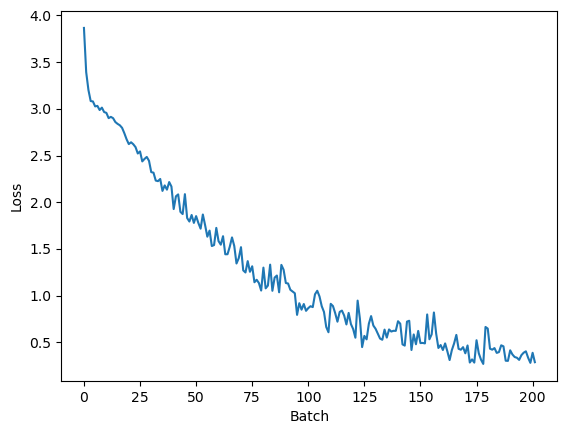

In [305]:
# Plotting the loss curve
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()


In [294]:
# Saving the model
torch.save(model.state_dict(), 'model1.pth')

# Loading the model
model.load_state_dict(torch.load('model1.pth'))
model.eval()



Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(89, 256)
    (gru): GRU(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(47, 256)
    (dropout): Dropout(p=0.5, inplace=True)
    (attention): Attention(
      (attn): Linear(in_features=512, out_features=256, bias=True)
    )
    (gru): GRU(512, 256, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=47, bias=True)
  )
)

In [173]:
# Implementing the greedy search
def greedy_search(model, source, max_len, start_symbol):
    with torch.no_grad():
        source = source.to(device)
        source = source.permute(1, 0)
        encoder_output, hidden = model.encoder(source)
        hidden = hidden[:model.decoder.n_layers]
        output = Variable(torch.ones(1, 1).fill_(start_symbol)).long().to(device)
        output =output.squeeze(0)
        sentence = []
        for t in range(max_len):
           # print(output.shape, hidden.shape, encoder_output.shape)
            output, hidden, attn_weights = model.decoder(
                    output, hidden, encoder_output)
            predicted = output.max(1)[1]
            sentence.append(predicted.item())
            output = Variable(predicted)
        return sentence

In [200]:
batch = next(iter(test_dataloader))
source = batch[0].to(device)
target = batch[1].to(device)

print(source.shape)
# Testing the model
outputs = greedy_search(model, source[0].unsqueeze(0), 500, target_vocab.char2idx['<sos>'])

for i in range(len(outputs)):
    print(target_vocab.idx2char[outputs[i]], end='')
# Printing the target
print("\n")
for i in range(len(target[0])):
    print(target_vocab.idx2char[target[0][i].item()], end='')


torch.Size([4, 376])
{"encoding": {"y": {"field": "str2", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "num2", "type": "quantitative", "bin": true}, "x": {"field": "num2", "type": "quantitative", "bin": true}, "x": {"field": "num2", "type": "quantitative", "bin": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, "mark": "bar"}<eos> "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, "mark": "bar"}<eos> "x": {"field": "*", "aggregate": "count", "type

<sos>{"encoding": {"x": {"field": "str4", "type": "nominal", "primitiveType": "string", "selected": true}, "y": {"field": "num3", "type": "quantitative", "aggregate": "mean"}}, "mark": "circle"}<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [211]:
import torch
from torch.autograd import Variable

def beam_search(model, source, max_len, start_symbol, beam_width=15):
    with torch.no_grad():
        source = source.to(device)
        source = source.permute(1, 0)
        encoder_output, hidden = model.encoder(source)
        hidden = hidden[:model.decoder.n_layers]
        output = Variable(torch.ones(1, 1).fill_(start_symbol)).long().to(device)
        output = output.squeeze(0)

        # Initialize beams for each sequence in the batch
        beams = [{'tokens': [start_symbol],
                  'score': 0.0,
                  'hidden': hidden,
                  'output': output} for _ in range(source.size(1))]

        for t in range(max_len):
            all_candidates = []

            for i, beam in enumerate(beams):
                current_token = Variable(torch.tensor([[beam['tokens'][-1]]])).to(device)
                current_hidden = beam['hidden']
                current_output = beam['output']

                # Decode the current token
                current_token = current_token.squeeze(0)
                output, hidden, attn_weights = model.decoder(
                    current_token, current_hidden, encoder_output)

                # Get the log probabilities for the next token
                log_probs = torch.log_softmax(output, dim=1)
                top_log_probs, top_tokens = torch.topk(log_probs, beam_width, dim=1)

                for j in range(beam_width):
                    candidate_token = top_tokens[0, j].item()
                    log_prob = top_log_probs[0, j].item()

                    candidate = {
                        'tokens': beam['tokens'] + [candidate_token],
                        'score': beam['score'] + log_prob,
                        'hidden': hidden,
                        'output': Variable(torch.tensor([[candidate_token]])).to(device)
                    }

                    all_candidates.append(candidate)

            # Sort the candidates by their scores
            ordered_candidates = sorted(all_candidates, key=lambda x: x['score'], reverse=True)

            # Select the top beam_width candidates for each sequence in the batch
            beams = [ordered_candidates[j] for j in range(beam_width)]

        # Return the tokens of the top beam_width beams for each sequence in the batch
        top_beams_tokens = [beam['tokens'] for beam in beams]
        return top_beams_tokens


In [214]:
batch = next(iter(test_dataloader))
source = batch[0].to(device)
target = batch[1].to(device)

print(source.shape)
# Testing the model
outputs = beam_search(model, source[0].unsqueeze(0), 500, target_vocab.char2idx['<sos>'])
# Print the best beam
for i in range(len(outputs[0])):
    print(target_vocab.idx2char[outputs[0][i]], end='')

# Printing the target
print("\n")
for i in range(len(target[0])):
    print(target_vocab.idx2char[target[0][i].item()], end='')


torch.Size([4, 376])
<sos>{"encoding": {"y": {"field": "str2", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "num2", "type": "quantitative", "bin": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "x": {"field": "*

<sos>{"encoding": {"x": {"field": "str8", "type": "nominal", "primitiveType": "string", "selected": true}, "y": {"field": "num1", "type": "quantitative", "bin": true}, "size": {"field": "*", "aggregate": "count", "type": "quantitative"}}, "mark": "point"}<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [213]:

# Printing the target
print("\n")
for i in range(len(target[0])):
    print(target_vocab.idx2char[target[0][i].item()], end='')

print("\n")
# Print the 15 outptus for the first sequence
for i in range(15):
    for j in range(len(outputs[i])):
        print(target_vocab.idx2char[outputs[i][j]], end='')
    print("\n")
    



<sos>{"encoding": {"y": {"field": "str1", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "num2", "type": "quantitative"}}, "mark": "tick"}<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

<sos>{"encoding": {"y": {"field": "str2", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "b

In [247]:
# Load the data from ./data/progression.json

import json
with open('./data/progression.json') as f:
    data = json.load(f)

# Convert it to str
data = [str(x) for x in data]
# Make it a single string
data = ' '.join(data)
# Append [ to the beginning and ] to the end
data = '[' + data + ']'

In [248]:
data

"[{'year': '1912', 'race': '100m', 'Time': '0.176666666666667', 'Distance': '0.1'} {'year': '1921', 'race': '100m', 'Time': '0.173333333333333', 'Distance': '0.1'} {'year': '1930', 'race': '100m', 'Time': '0.171666666666667', 'Distance': '0.1'} {'year': '1936', 'race': '100m', 'Time': '0.17', 'Distance': '0.1'} {'year': '1956', 'race': '100m', 'Time': '0.168333333333333', 'Distance': '0.1'} {'year': '1960', 'race': '100m', 'Time': '0.166666666666667', 'Distance': '0.1'} {'year': '1968', 'race': '100m', 'Time': '0.165833333333333', 'Distance': '0.1'} {'year': '1983', 'race': '100m', 'Time': '0.1655', 'Distance': '0.1'} {'year': '1988', 'race': '100m', 'Time': '0.165333333333333', 'Distance': '0.1'} {'year': '1991', 'race': '100m', 'Time': '0.165', 'Distance': '0.1'} {'year': '1991', 'race': '100m', 'Time': '0.164333333333333', 'Distance': '0.1'} {'year': '1994', 'race': '100m', 'Time': '0.164166666666667', 'Distance': '0.1'} {'year': '1996', 'race': '100m', 'Time': '0.164', 'Distance': 

In [265]:
# Create dataset item
data_target = data[1:]

progression_dataset=Dataset([data], [data_target], source_vocab, target_vocab, len(data), len(data_target))

progression_dataloader = torch.utils.data.DataLoader(progression_dataset, batch_size=1, shuffle=True)

In [308]:
# Pass this single string to the greedy search
batch = next(iter(progression_dataloader))
source = batch[0].to(device)
target = batch[1].to(device)

print(source.shape)
# Testing the model

outputs = greedy_search(model, source[0].unsqueeze(0), 2000, target_vocab.char2idx['<sos>'])

for i in range(len(outputs)):
    print(target_vocab.idx2char[outputs[i]], end='')



torch.Size([1, 11616])
{"encoding": {"y": {"field": "num5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "bin": true}, "y": {"field": "*um5", "type": "quantitative", "

In [309]:
outputs = beam_search(model, source[0].unsqueeze(0), 2000, target_vocab.char2idx['<sos>'])

In [310]:
# Print all the 15 outputs
for i in range(15):
    for j in range(len(outputs[i])):
        print(target_vocab.idx2char[outputs[i][j]], end='')
    print("\n")

<sos>{"encoding": {"y": {"field": "str5", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field": "*", "aggregate": "count", "type": "quantitative", "bin": true}, "y": {"field"

In [311]:
# Save all the 15 outputs in a file
with open('progression.txt', 'w') as f:
    for i in range(15):
        for j in range(len(outputs[i])):
            f.write(target_vocab.idx2char[outputs[i][j]])
        f.write("\n")
        

Will give good results if the model is allowed to train on the entire training data. Paper was able to run with much higher number of epochs and batch size, and encoding dimensions. The paper used 32 as the batch size, while my system was running into out of memory errors for batch size > 4.


Training on 800 samples took 10 minutes on my system.
20000 steps was suggested in the paper for a batch size of 32, i.e a total of 20000 * 32 = 640000 samples. So, training on my system will take 640000*10/800 = 8000 minutes = 133 hours = 5.5 days.